<table> 
    <tr>
        <td  style="background-color:#ffffff;"><a href="https://qsoftware.lu.lv/index.php/qworld/" target="_blank"><img src="..\Images\qworld.jpg" width="70%" align="left"></a></td>
        <td style="background-color:#ffffff;" width="*"></td>
        <td  style="background-color:#ffffff;vertical-align:text-top;"><a href="https://qsoftware.lu.lv" target="_blank"><img src="..\Images\qturkey.png" width="50%" align="right"></a></td>        
    </tr></table>
<table><tr style="background-color:white;">
    <td>Follow Us (QWorld)</td>
    <td><a href="https://www.facebook.com/qworld19/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QWorld19" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QLatvia</td>
    <td><a href="https://www.facebook.com/QLatviaSoftware/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/QLatviaSoftware" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td>Follow QTurkey</td>
    <td><a href="https://www.facebook.com/groups/290363815207623/" target="_blank"><img src="../Images/facebook-icon.png" width="30px"></a></td>
    <td><a href="https://twitter.com/KuantumTurkiye" target="_blank"><img src="../Images/twitter-icon.png" width="30px"></a></td>
    </tr></table>

# Transfer Learning

Transfer Learning Tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [17]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [19]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

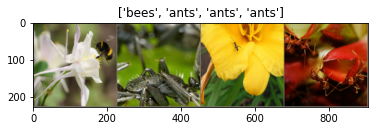

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5010 Acc: 0.7295
val Loss: 0.2196 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.3504 Acc: 0.8238
val Loss: 0.4585 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5910 Acc: 0.7910
val Loss: 0.2053 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3858 Acc: 0.8361
val Loss: 0.3451 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3600 Acc: 0.8484
val Loss: 0.5266 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.5009 Acc: 0.8197
val Loss: 0.3113 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.7010 Acc: 0.7582
val Loss: 0.2618 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3800 Acc: 0.8566
val Loss: 0.1768 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3875 Acc: 0.8279
val Loss: 0.1948 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3707 Acc: 0.8484
val Loss: 0.1767 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2408 Acc: 0.9057
val Loss: 0.1879 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2747 Acc: 0.8770
val Loss: 0.1678 Acc: 0.9412

Ep

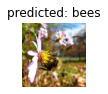

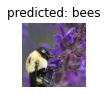

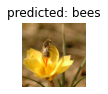

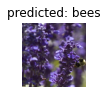

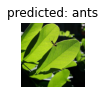

In [25]:
visualize_model(model_ft)

In [26]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5447 Acc: 0.6762
val Loss: 0.2140 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4126 Acc: 0.7992
val Loss: 0.1926 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5025 Acc: 0.7705
val Loss: 0.1943 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5742 Acc: 0.7623
val Loss: 0.1782 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5670 Acc: 0.7623
val Loss: 0.3879 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.5150 Acc: 0.7951
val Loss: 0.1833 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5107 Acc: 0.7746
val Loss: 0.2032 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4172 Acc: 0.8484
val Loss: 0.2079 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3642 Acc: 0.8197
val Loss: 0.1666 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3017 Acc: 0.8484
val Loss: 0.1995 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4021 Acc: 0.8238
val Loss: 0.1810 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2961 Acc: 0.8811
val Loss: 0.1711 Acc: 0.9477

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Quantum Transfer Learning

Quantum Transfer Learning Tutorial: https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html

#### 1. Importing

In [1]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

# Plotting
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

#### 2. Setting of the main hyper-parameters of the model

In [2]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 30             # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
rng_seed = 0                # Seed for random number generator
start_time = time.time()    # Start of the computation timer

In [3]:
#Initializing the devices 
#We initialize a PennyLane device with a default.qubit backend.
dev = qml.device("default.qubit", wires=n_qubits)

#We configure PyTorch to use CUDA only if available. Otherwise the CPU is used.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 3. Dataset loading

In [4]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "../data/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

##### 3. a. Check the loaded data

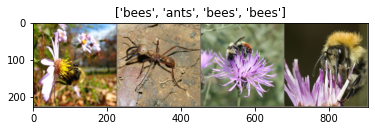

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# In order to get reproducible results, we set a manual seed for the
# random number generator and re-initialize the dataloaders.

torch.manual_seed(rng_seed)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

#### 4. Variational quantum circuit
We first define some quantum layers that will compose the quantum circuit.

In [6]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Now we define the quantum circuit through the PennyLane qnode decorator .

The structure is that of a typical variational quantum circuit:

- **Embedding layer:** All qubits are first initialized in a balanced superposition of up and down states, then they are rotated according to the input parameters (local embedding).
- **Variational layers:** A sequence of trainable rotation layers and constant entangling layers is applied.
- **Measurement layer:** For each qubit, the local expectation value of the 
Z
 operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [7]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

#### 5. Dressed quantum circuit
We can now define a custom torch.nn.Module representing a dressed quantum circuit.

This is a concatenation of:

- A classical pre-processing layer (nn.Linear).
- A classical activation function (torch.tanh).
- A constant np.pi/2.0 scaling.
- The previously defined quantum circuit (quantum_net).
- A classical post-processing layer (nn.Linear).

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: ants and bees).

In [8]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

#### 6. Hybrid classical-quantum model
We are finally ready to build our full hybrid classical-quantum network. We follow the transfer learning approach:

1. First load the classical pre-trained network ResNet18 from the torchvision.models zoo.
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet).

In [9]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

#### 7. Training and results
Before training the network we need to specify the loss function.

We use, as usual in classification problem, the cross-entropy which is directly available within torch.nn.

In [10]:
criterion = nn.CrossEntropyLoss()

We also initialize the Adam optimizer which is called at each training step in order to update the weights of the model.

In [11]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of gamma_lr_scheduler every 10 epochs.

In [12]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications).

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                scheduler.step()
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

We are ready to perform the actual training process.

In [14]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)

Training started:


/home/ayshine/anaconda3/envs/QML/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Phase: train Epoch: 1/30 Loss: 0.6916 Acc: 0.5164        
Phase: validation   Epoch: 1/30 Loss: 0.6475 Acc: 0.6732        
Phase: train Epoch: 2/30 Loss: 0.6273 Acc: 0.6680        
Phase: validation   Epoch: 2/30 Loss: 0.4934 Acc: 0.8105        
Phase: train Epoch: 3/30 Loss: 0.5337 Acc: 0.7377        
Phase: validation   Epoch: 3/30 Loss: 0.4259 Acc: 0.8497        
Phase: train Epoch: 4/30 Loss: 0.4564 Acc: 0.8320        
Phase: validation   Epoch: 4/30 Loss: 0.3469 Acc: 0.9150        
Phase: train Epoch: 5/30 Loss: 0.4682 Acc: 0.7746        
Phase: validation   Epoch: 5/30 Loss: 0.3305 Acc: 0.9150        
Phase: train Epoch: 6/30 Loss: 0.3988 Acc: 0.8402        
Phase: validation   Epoch: 6/30 Loss: 0.3135 Acc: 0.9477        
Phase: train Epoch: 7/30 Loss: 0.3625 Acc: 0.8730        
Phase: validation   Epoch: 7/30 Loss: 0.2937 Acc: 0.9346        
Phase: train Epoch: 8/30 Loss: 0.3621 Acc: 0.8689        
Phase: validation   Epoch: 8/30 Loss: 0.2863 Acc: 0.9216        
Phase: train Epo

#### 8. Visualizing the model predictions
We first define a visualization function for a batch of test data.

In [15]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with the corresponding predictions.

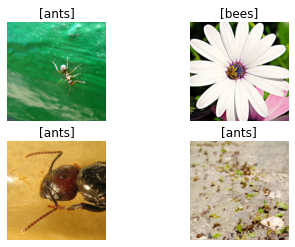

In [16]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()